# Lab 3: Post Transforms
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/MONAIBootcamp2020/blob/master/day1notebooks/lab3_post_transforms.ipynb)

### Overview

This notebook introduces you to the MONAI APIs for:
- sliding window inference 
- post-processing transforms

## Install MONAI and the extras
This section installs the latest version of MONAI and validates the install by printing out the configuration.

In [2]:
!pip install -qU "monai[nibabel, tqdm]==0.3.0rc4"

import monai
monai.config.print_config()

     |████████████████████████████████| 296kB 6.2MB/s 
MONAI version: 0.3.0rc2
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
Numpy version: 1.18.5
Pytorch version: 1.6.0+cu101

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.0.0
Tensorboard version: 2.3.0
gdown version: 3.6.4
TorchVision version: 0.7.0+cu101
ITK version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Sliding window inference

### A toy model for inference
The [sliding_window_inference](https://docs.monai.io/en/latest/inferers.html?highlight=sliding#sliding-window-inference) requires a callable function which takes a batch of image windows as the input.

Here we construct a toy model. It has a single model parameter, `self.pred`.
The inference outcome is just `input + self.pred`.

Every time the model is called, it also increases `self.pred` by one. This is
to demonstrate that the model can be "stateful", and also so that we can conveniently visualize the inference outputs.

In [3]:
class ToyModel:
    # A simple model generates the output by adding an integer `pred` to input.
    # each call of this instance increases the integer by 1.
    pred = 0
    def __call__(self, input):
        self.pred = self.pred + 1
        return input + self.pred

### Run the inference using sliding window

We're going to create a 200x200-pixel image and pass it to `sliding_window_inference` with a 40x40 window size then display the image.

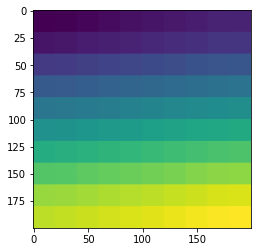

In [4]:
import torch
import matplotlib.pyplot as plt
from monai.inferers import sliding_window_inference

input_tensor = torch.zeros(1, 1, 200, 200)
output_tensor = sliding_window_inference(
    inputs=input_tensor, 
    predictor=ToyModel(), 
    roi_size=(40, 40), 
    sw_batch_size=1, 
    overlap=0.5, 
    mode="constant")
plt.imshow(output_tensor[0, 0])

### Gaussian weighted windows
For a given input image window, the convolutional neural networks often predict the central regions more accurately than the border regions, usually due to the stacked convolutions' receptive field.

Therefore, it is worth considering a "Gaussian weighted" prediction to emphasize the central region predictions when we stitch the windows into a complete inference output.

The following is an example of a 40x40-pixel Gaussian window map constructed using [GaussianFilter](https://docs.monai.io/en/latest/networks.html?highlight=gaus#gaussianfilter) from MONAI. This is also integrated into the sliding window module.

torch.Size([40, 40])


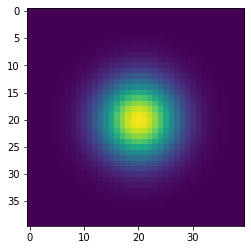

In [5]:
win_size = (40, 40)
gaussian = torch.zeros(win_size, device="cpu")
center_coords = [i // 2 for i in win_size]
sigmas = [i * 0.125 for i in win_size]
gaussian[tuple(center_coords)] = 1
pt_gaussian = monai.networks.layers.GaussianFilter(len(win_size), sigma=sigmas).to(device="cpu", dtype=torch.float)
gaussian = pt_gaussian(gaussian.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
print(gaussian.shape)

plt.imshow(gaussian)

By simply changing the inference `mode` to `"gaussian"`, the sliding window module will use this "weighted stitching".

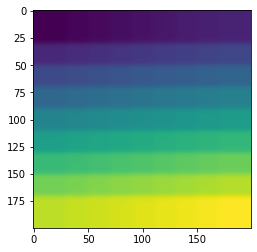

In [6]:
input_tensor = torch.zeros(1, 1, 200, 200)
output_tensor_1 = sliding_window_inference(
    inputs=input_tensor, 
    predictor=ToyModel(), 
    roi_size=(40, 40), 
    sw_batch_size=1, 
    overlap=0.5, 
    mode="gaussian")
plt.imshow(output_tensor_1[0, 0])

Compared with the previous inferences, the overlapping windows are stitched together with fewer border artifacts.

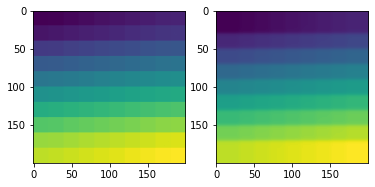

In [7]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1); plt.imshow(output_tensor[0, 0])
plt.subplot(1, 2, 2); plt.imshow(output_tensor_1[0, 0])

## Post-processing transforms
This section will set up and load a [SegResNet](https://docs.monai.io/en/latest/networks.html?highlight=segresnet#segresnet) model, run sliding window inference, and post-process the model output volumes:
- Argmax to get a discrete prediction map
- Remove small isolated predicted regions
- Convert the segmentation regions into contours

We'll start by importing all of our dependencies.

In [18]:
import os
import glob

from monai.apps import download_and_extract
from monai.utils import set_determinism
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import SegResNet
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    Compose,
    CropForegroundd,
    KeepLargestConnectedComponent,
    LabelToContour,
    LoadNiftid,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    ToTensord,
)

### Download image and labels

We'll download the .tar file for Task09_Spleen from the link below.  We'll then extract the data, so it's ready to use in the next section.

In [12]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

root_dir = '.'
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
download_and_extract(resource, compressed_file, root_dir, md5)

1610352640/1610352640 [==============================]
Verified 'Task09_Spleen.tar.part', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.


### Set up the validation data, preprocessing transforms, and data loader

We'll put the data and labels into a data dictionary, create a sequence of transforms with `Compose`, using a `CacheDataset`, and then load the data using `DataLoader`.

In [19]:
images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]
val_files = data_dicts[-9:]

val_transforms = Compose(
    [
        LoadNiftid(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

9/9 Load and cache transformed data:  [==============================]


### Set up the model

We want to utilize the GPU, so we'll check to see if it's available and set it as the primary device; otherwise we'll use the CPU.

We'll then instantiate the model with the selected device.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
).to(device)

In [42]:
model_path = os.path.join(root_dir, "segresnet_model_epoch30.pth")
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"model from {model_path}.")

model from ./segresnet_model_epoch30.pth.


### Run the sliding window inference

In [43]:
val_data = next(iter(val_loader))
val_data = val_data["image"].to(device)

roi_size = (160, 160, 160)
sw_batch_size = 4
with torch.no_grad():
  val_output = sliding_window_inference(val_data, roi_size, sw_batch_size, model)
print(val_output.shape, val_output.device)
slice_idx = 80
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_output.detach().cpu()[0, 1, :, :, 80], cmap="gray")

torch.Size([1, 2, 226, 157, 113]) cuda:0


Note that the aggregated output are colocated on the same device as the original input.

Could also try other sliding window parameters:

In [ ]:
roi_size = (88, 88, 88)
sw_batch_size = 1
with torch.no_grad():
  val_output = sliding_window_inference(
      val_data, roi_size, sw_batch_size=sw_batch_size, predictor=model, mode="gaussian", overlap=0.2)
print(val_output.shape, val_output.device)

slice_idx = 80
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_output.detach().cpu()[0, 1, :, :, 80], cmap="gray")

### Post-processing: argmax over the output probabilities into a discrete map

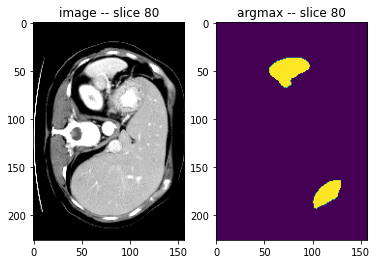

In [44]:
argmax = AsDiscrete(argmax=True)(val_output)
print(argmax.shape)

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"argmax -- slice {slice_idx}")
plt.imshow(argmax.detach().cpu()[0, 0, :, :, 80])

### Post-processing: connected component analysis to select the largest segmentation region

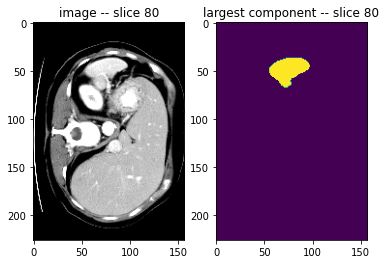

In [45]:
largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
print(largest.shape)

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"largest component -- slice {slice_idx}")
plt.imshow(largest.detach().cpu()[0, 0, :, :, 80])

### Post-processing: convert the region into a contour map

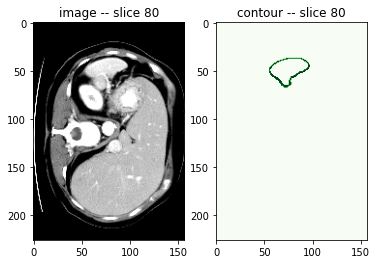

In [46]:
contour = LabelToContour()(largest)
print(contour.shape)

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"contour -- slice {slice_idx}")
plt.imshow(contour.detach().cpu()[0, 0, :, :, 80], cmap="Greens")

To visualise the contour over the original input:

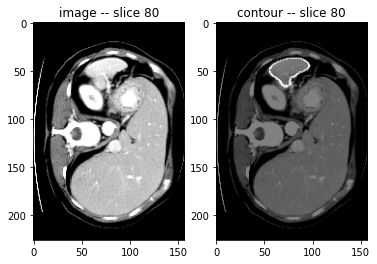

In [41]:
map_image = contour + val_data

slice_idx = 80
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.title(f"image -- slice {slice_idx}")
plt.imshow(val_data.detach().cpu()[0, 0, :, :, 80], cmap="gray")

plt.subplot(1, 2, 2)
plt.title(f"contour -- slice {slice_idx}")
plt.imshow(map_image.detach().cpu()[0, 0, :, :, 80], cmap="gray")

For more details about the post-postprocessing transformations, please visit:
https://docs.monai.io/en/latest/transforms.html#post-processing-dict

Visualising the results in animation with tensorboard (please start `tensorboard` manually in a separate terminal):

In [ ]:
from monai.visualize import plot_2d_or_3d_image
from torch.utils.tensorboard import SummaryWriter

with SummaryWriter(log_dir=root_dir) as writer:
    plot_2d_or_3d_image(map_image, step=0, writer=writer, tag="segmentation")
    plot_2d_or_3d_image(val_output, step=0, max_channels=2, writer=writer, tag="Probability")

## Summary

In this notebook, you learned about you MONAI's APIs for:
- Sliding Window inference using constant and gaussian modes
- Multiple post-processing transforms methods


For full API documentation, please visit https://docs.monai.io.